In [1]:
from scipy.stats import rv_continuous
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

class frechet_distribution_gen(rv_continuous):
    "Frechet distribution"
    def _pdf(self, x, shape, scale_param):
        return scale_param * shape * x ** (-1 - shape) * np.exp(- scale_param * x ** -shape)
    
    def _cdf(self, x, shape, scale_param):
        return np.exp(- scale_param * x ** -shape)
    
    def _get_support(self, *args):
        return (0, np.inf)

# Create a frozen instance of our distribution
frechet_distribution = frechet_distribution_gen(name='frechet')

def frechet_draws(shape, scale_param, size=1):
    return frechet_distribution.rvs(shape, scale_param, size=size)

def draw_samples(shape, scale_matrix, size=1):
    # Initialize an array to store the samples
    samples = np.empty(scale_matrix.shape)

    # Draw samples for each scale parameter in the matrix
    for i in range(scale_matrix.shape[0]):
        for j in range(scale_matrix.shape[1]):
            samples[i, j] = frechet_distribution.rvs(shape[i, j], scale_matrix[i, j], size=size)

    return samples

def get_city(shapes, scales, rho_values):
    scales = np.array(scales) ** (1 / (1 - np.array(rho_values)))
    shapes = np.array(shapes) * (1 / (1 - np.array(rho_values)))
    draws = draw_samples(shapes, scales)
    max_col_index = np.unravel_index(np.argmax(draws), draws.shape)[1]
    max_row_index = np.unravel_index(np.argmax(draws), draws.shape)[0]
    return max_row_index, max_col_index

def get_location_choice(shapes, scales, rho_values, n):
    df = pd.DataFrame(0, index=range(len(scales)), columns=range(len(scales[0])))
    for i in tqdm(range(n)):
        max_city, max_occupation = get_city(shapes, scales, rho_values)
        # If the city and occupation combination doesn't exist, create it with a count of 1
        if max_city not in df.index or max_occupation not in df.columns:
            df.loc[max_city, max_occupation] = 1
        else:
            # If the city and occupation combination exists, increment the count
            df.loc[max_city, max_occupation] += 1
    return df

def plot_hist(df, filename=None):
    # Reset the index
    df_reset = df.reset_index()

    # Reshape the DataFrame
    df_melted = df_reset.melt(id_vars='index', var_name='Occupation', value_name='Value')

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='index', y='Value', hue='Occupation', data=df_melted)

    # Add numbers on top of the bars
    for p in barplot.patches:
        height = p.get_height()
        if height != 0:  # Add this condition
            barplot.annotate(format(height, '.1f'), 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 10), 
                            textcoords = 'offset points')
    barplot.set(xlabel='City', ylabel='Number of Households')
    if filename:
        plt.savefig(filename)
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_41443/1222050272.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples[i, j] = frechet_distribution.rvs(shape[i, j], scale_matrix[i, j], size=size)
100%|██████████| 10000/10000 [00:34<00:00, 291.87it/s]


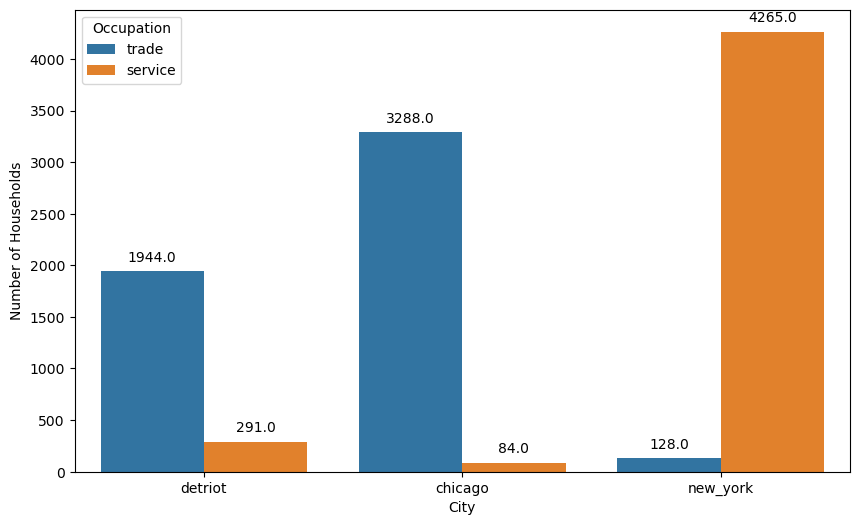

In [4]:
# Assume two occupations, trades and services 
# Assume 3 cities and 2 household types 

# City types
detriot_t = np.array([0.7, 0.2]) * 10
chicago_t = np.array([0.8, 0.1]) * 10
new_york_s = np.array([0.3, 0.8]) * 10

# Assume some parameters 
shape = 2
rho_values = [0.7, 0.5]

city_names = ['detriot', 'chicago', 'new_york']
ocupation_names = ['trade', 'service']

# Set up matrices
scales = np.vstack((detriot_t, chicago_t, new_york_s))
shapes = np.ones(scales.shape) * shape

location_choice = get_location_choice(shapes, scales, rho_values, 10000)
location_choice.index = city_names
location_choice.columns = ocupation_names

plot_hist(location_choice, 'graphs/city_pop.png')

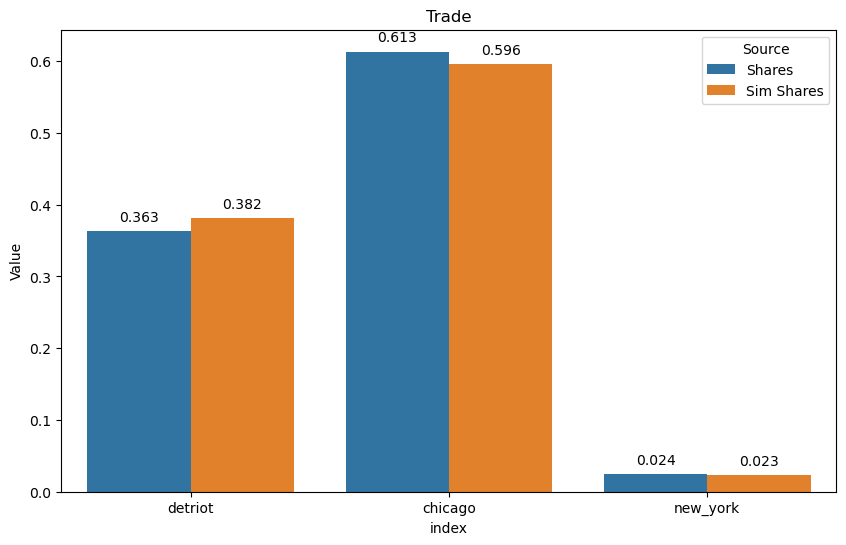

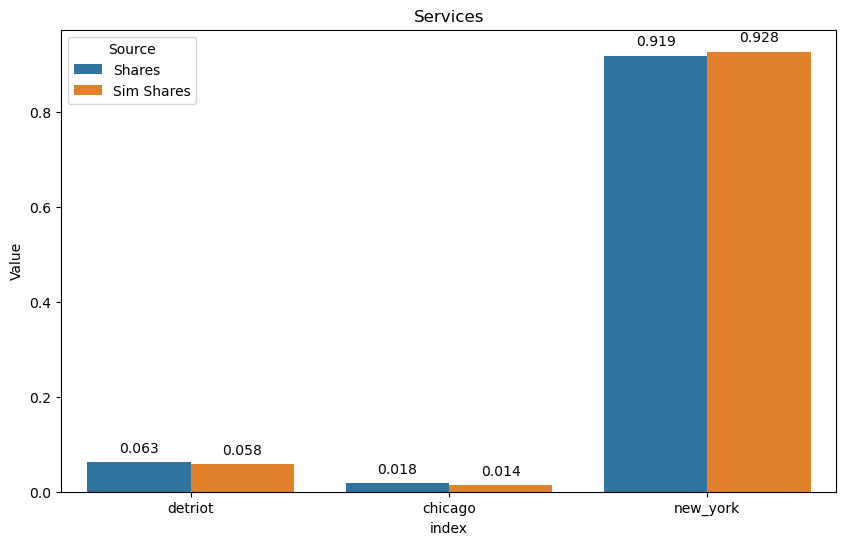

In [17]:
shares = location_choice.copy()
shares.loc['total'] = shares.sum(axis=0)
shares = shares.div(shares.loc['total'])
shares = shares.drop('total')

sim_shares = scales ** (1 / (1 - np.array(rho_values)))
sim_shares = pd.DataFrame(sim_shares, index=city_names, columns=ocupation_names)
sim_shares.loc['total'] = sim_shares.sum(axis=0)
sim_shares = sim_shares.div(sim_shares.loc['total'])
sim_shares = sim_shares.drop('total')

# Reshape the dataframes
shares_melted = shares.reset_index().melt(id_vars='index', var_name='Occupation', value_name='Value')
sim_shares_melted = sim_shares.reset_index().melt(id_vars='index', var_name='Occupation', value_name='Value')

# Add a column to each to indicate the source dataframe
shares_melted['Source'] = 'Shares'
sim_shares_melted['Source'] = 'Sim Shares'

# Concatenate the dataframes
df = pd.concat([shares_melted, sim_shares_melted])

# Filter the data for the 'Trade' occupation
trade_df = df[df['Occupation'] == 'trade']

# Create the plot for the 'Trade' occupation
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='index', y='Value', hue='Source', data=trade_df)
barplot.set(xlabel='City', ylabel='Share of Households')
plt.title('Trade')
for p in barplot.patches:
        height = p.get_height()
        if height != 0:  # Add this condition
            barplot.annotate(format(height, '.3f'), 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 10), 
                            textcoords = 'offset points')
plt.savefig('graphs/sim_trade.png')
plt.show()

# Filter the data for the 'Services' occupation
services_df = df[df['Occupation'] == 'service']

# Create the plot for the 'Services' occupation
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='index', y='Value', hue='Source', data=services_df)
barplot.set(xlabel='City', ylabel='Share of Households')
plt.title('Services')
for p in barplot.patches:
        height = p.get_height()
        if height != 0:  # Add this condition
            barplot.annotate(format(height, '.3f'), 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 10), 
                            textcoords = 'offset points')
plt.savefig('graphs/sim_services.png')
plt.show()

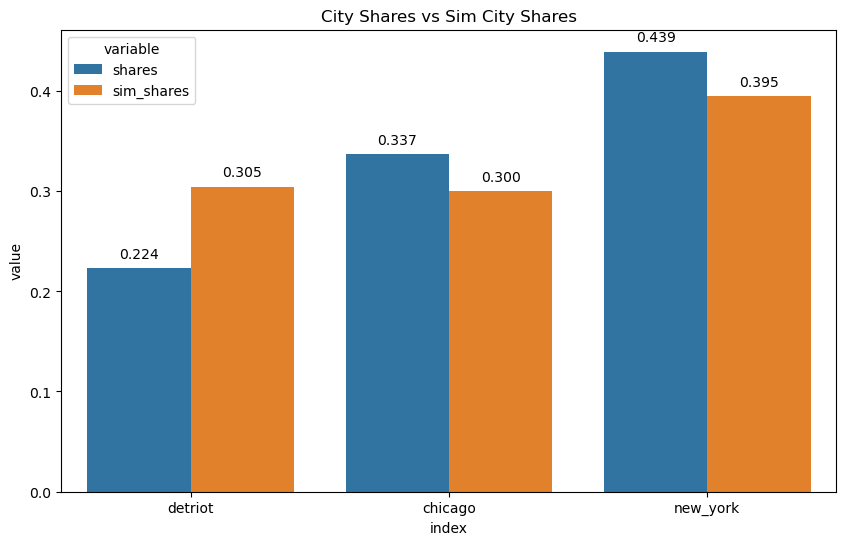

In [48]:
city_shares = location_choice.copy()
city_shares['city_total'] = city_shares.sum(axis=1)
city_shares.loc['occ_total'] = city_shares.sum(axis=0)
city_shares = city_shares.div(city_shares.loc['occ_total'])
city_shares = city_shares.drop('occ_total', axis=0)
city_shares = city_shares['city_total']

sim_city_shares = sim_shares.copy().values ** (1 - np.array(rho_values))
sim_city_shares = pd.DataFrame(sim_city_shares, index=city_names, columns=ocupation_names)
sim_city_shares['city_total'] = sim_city_shares.sum(axis=1)
sim_city_shares.loc['occ_total'] = sim_city_shares.sum(axis=0)
sim_city_shares = sim_city_shares['city_total']
sim_city_shares = sim_city_shares.div(sim_city_shares.loc['occ_total'])
sim_city_shares = sim_city_shares.drop('occ_total', axis=0)

city_shares_df = city_shares.to_frame('shares')
sim_city_shares_df = sim_city_shares.to_frame('sim_shares')

combo = pd.concat([city_shares_df, sim_city_shares_df], axis=1)
plt.figure(figsize=(10, 6))
combo_reset = combo.reset_index()
melted_combo = combo_reset.melt(id_vars='index', var_name='variable', value_name='value')
barplot = sns.barplot(x='index', y='value', hue='variable', data=melted_combo)
barplot.set(xlabel='City', ylabel='Share of Households')
plt.title('City Shares vs Sim City Shares')
for p in barplot.patches:
        height = p.get_height()
        if height != 0:  # Add this condition
            barplot.annotate(format(height, '.3f'), 
                            (p.get_x() + p.get_width() / 2., height), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 10), 
                            textcoords = 'offset points')
plt.savefig('graphs/sim_city_shares.png')


  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_41443/1222050272.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples[i, j] = frechet_distribution.rvs(shape[i, j], scale_matrix[i, j], size=size)
100%|██████████| 10000/10000 [00:36<00:00, 270.57it/s]


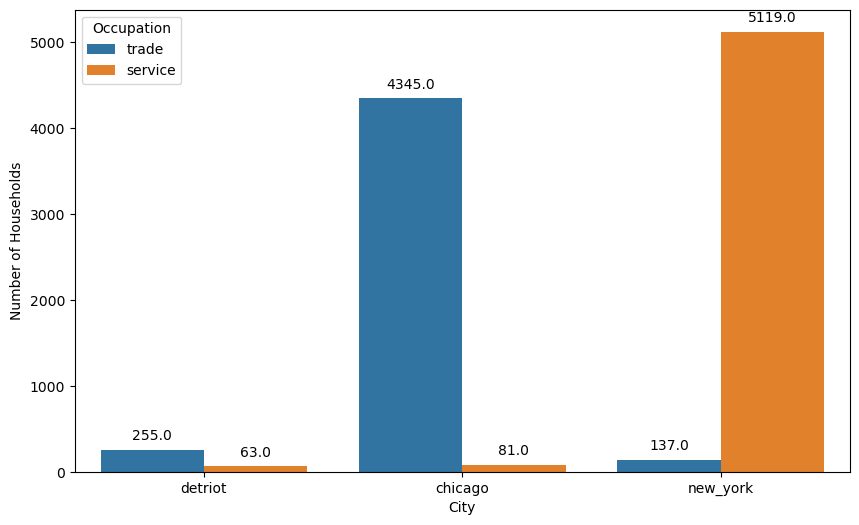

In [3]:
# Shock detriot
detroit_shock = detriot_t * 0.5

scales = np.vstack((detroit_shock, chicago_t, new_york_s))

location_choice = get_location_choice(shapes, scales, rho_values, 10000)
location_choice.index = city_names
location_choice.columns = ocupation_names

plot_hist(location_choice, 'graphs/c_shock.png')